In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.special import inv_boxcox

In [2]:
house_price_dataset = sklearn.datasets.fetch_california_housing()
house_price_dataframe = pd.DataFrame(house_price_dataset.data,columns = house_price_dataset.feature_names)
house_price_dataframe['Price'] = house_price_dataset.target

In [5]:
# 初始化异常值索引列表
outliers_indexes = []
target = 'Price'

# 处理分类变量
# 获取分类变量的组别 col
# 获取每个组别中的唯一分类 cat 
# 为每个分类创建一个 DataFrame df1
        
# 处理数值变量        
for col in house_price_dataframe.columns:
    q1 = house_price_dataframe[col].quantile(0.25)
    q3 = house_price_dataframe[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = house_price_dataframe[(house_price_dataframe[col] < minimum) | (house_price_dataframe[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())

# 去重并输出结果   
outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

4328 outliers were identified, whose indices are:

[0, 1, 16385, 8196, 9770, 16397, 8206, 8208, 8209, 8210, 16402, 8212, 16405, 8216, 8217, 16410, 8219, 16412, 8221, 16413, 16414, 8218, 8220, 16420, 16423, 8232, 41, 8234, 16424, 8247, 8248, 57, 8249, 59, 8250, 61, 62, 63, 64, 8251, 8258, 67, 68, 8252, 72, 73, 8268, 9785, 85, 8278, 89, 91, 92, 94, 95, 8290, 8291, 8299, 8304, 8305, 8306, 8307, 8309, 8311, 8314, 8315, 8316, 8317, 131, 134, 135, 137, 140, 16528, 16534, 154, 155, 8349, 16544, 8355, 16553, 16559, 16566, 16567, 8375, 185, 8376, 16568, 189, 192, 8384, 8388, 16582, 200, 8395, 16591, 16593, 16594, 8403, 8402, 16598, 8406, 8410, 8412, 16606, 8415, 8416, 8417, 8418, 8414, 16612, 16613, 16614, 16615, 16616, 16617, 16618, 8424, 16620, 16621, 8187, 8431, 8432, 16623, 16624, 16626, 8188, 247, 252, 16638, 16642, 16643, 270, 17964, 8467, 8468, 16662, 8475, 283, 16669, 10106, 16673, 8481, 16672, 16677, 303, 8501, 314, 16698, 16702, 322, 323, 16706, 16711, 8520, 17976, 8523, 17977, 343, 1

In [7]:
numeric_features = house_price_dataframe.columns

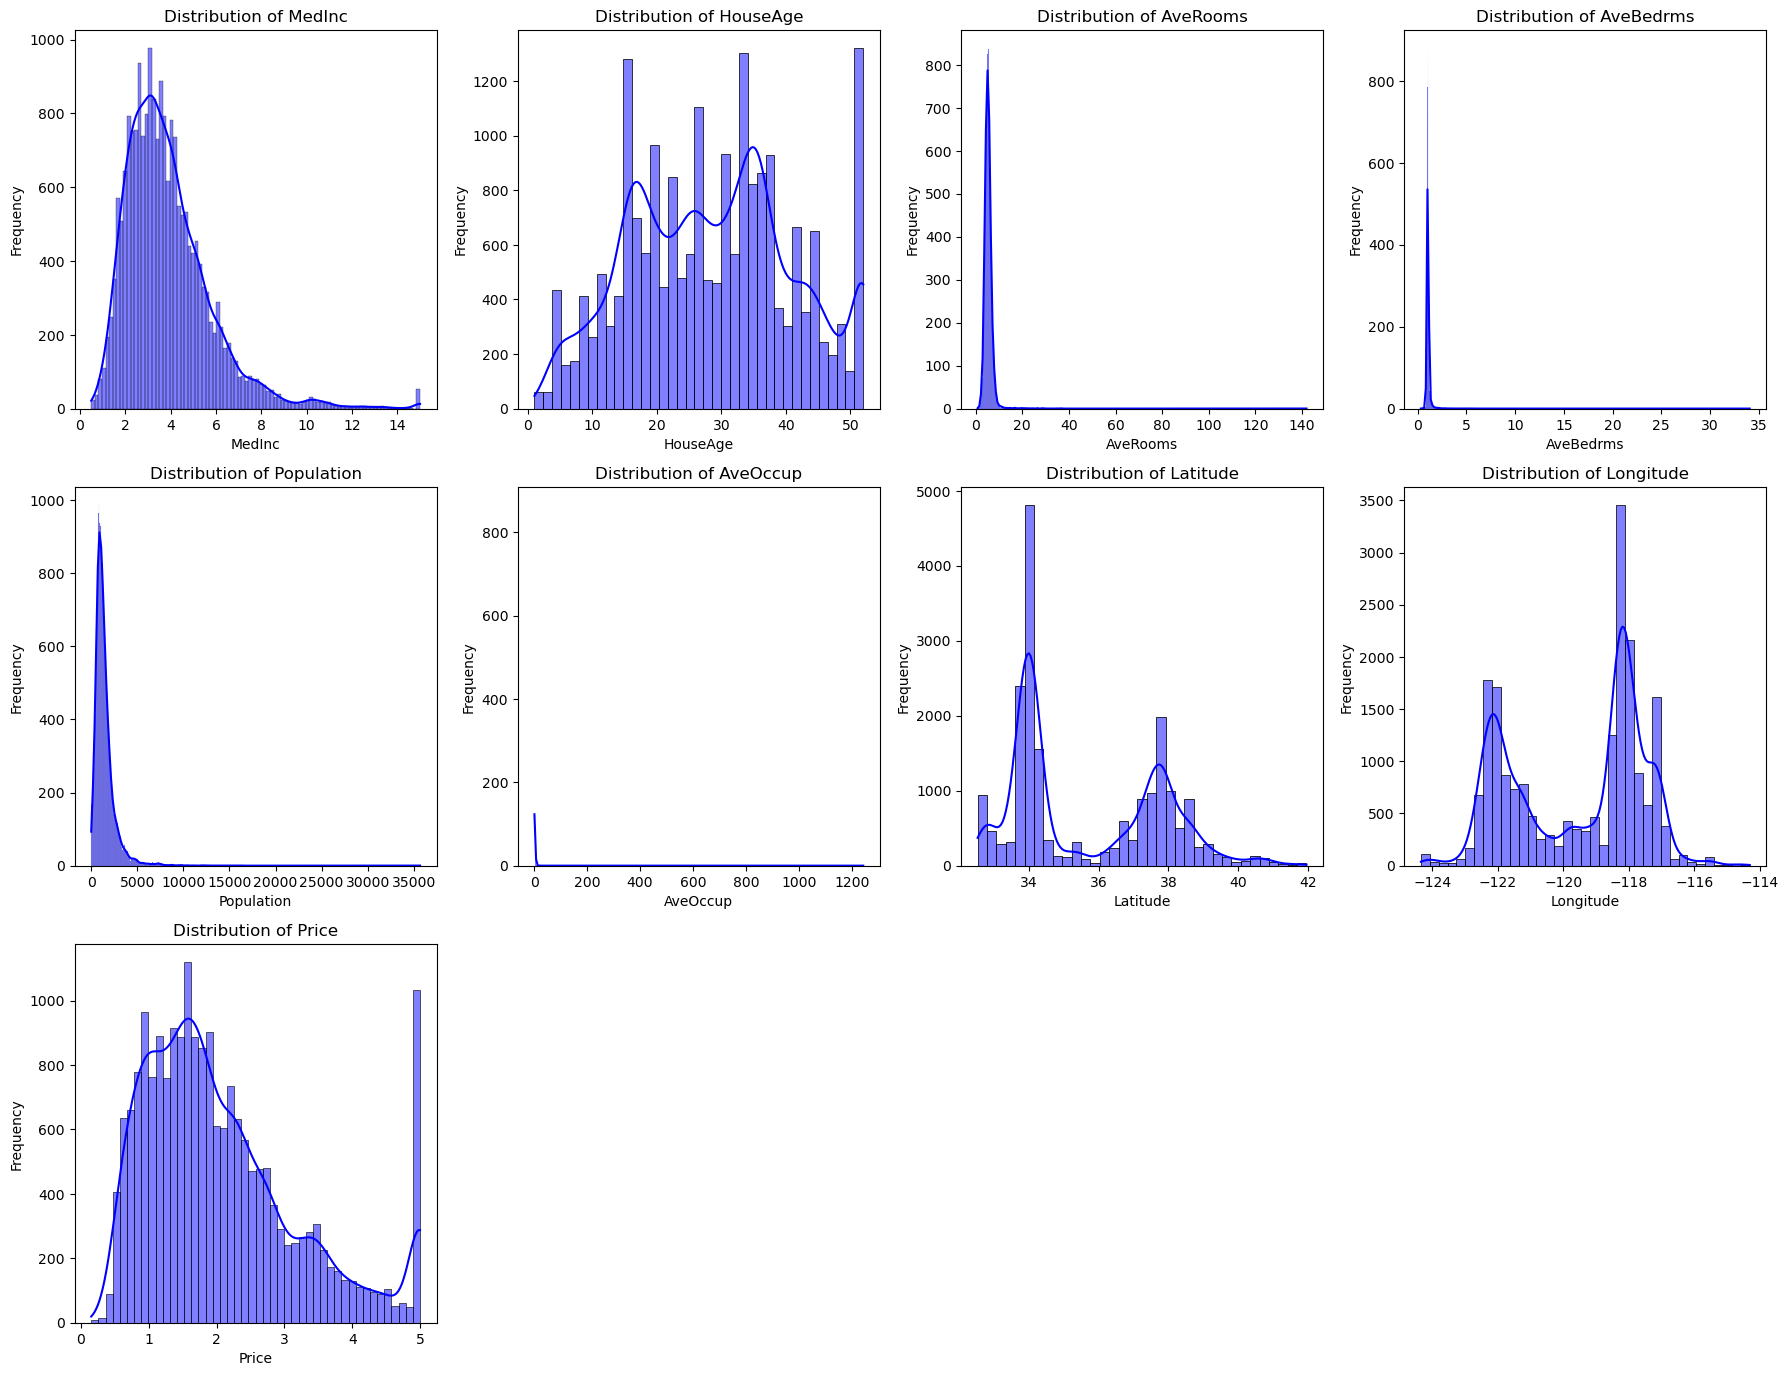

In [9]:
plt.figure(figsize=(18, 18))

# 绘制每个特征的直方图和核密度估计曲线
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(4, 4, i)  # 假设最多显示16个特征，你可以根据实际需要调整
    sns.histplot(house_price_dataframe[feature], kde=True, bins='auto', color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Frequency')
# 调整布局以防止标签重叠
plt.savefig("房价预测-特征分布图.png", dpi=300, bbox_inches='tight') 
plt.tight_layout()
plt.show()

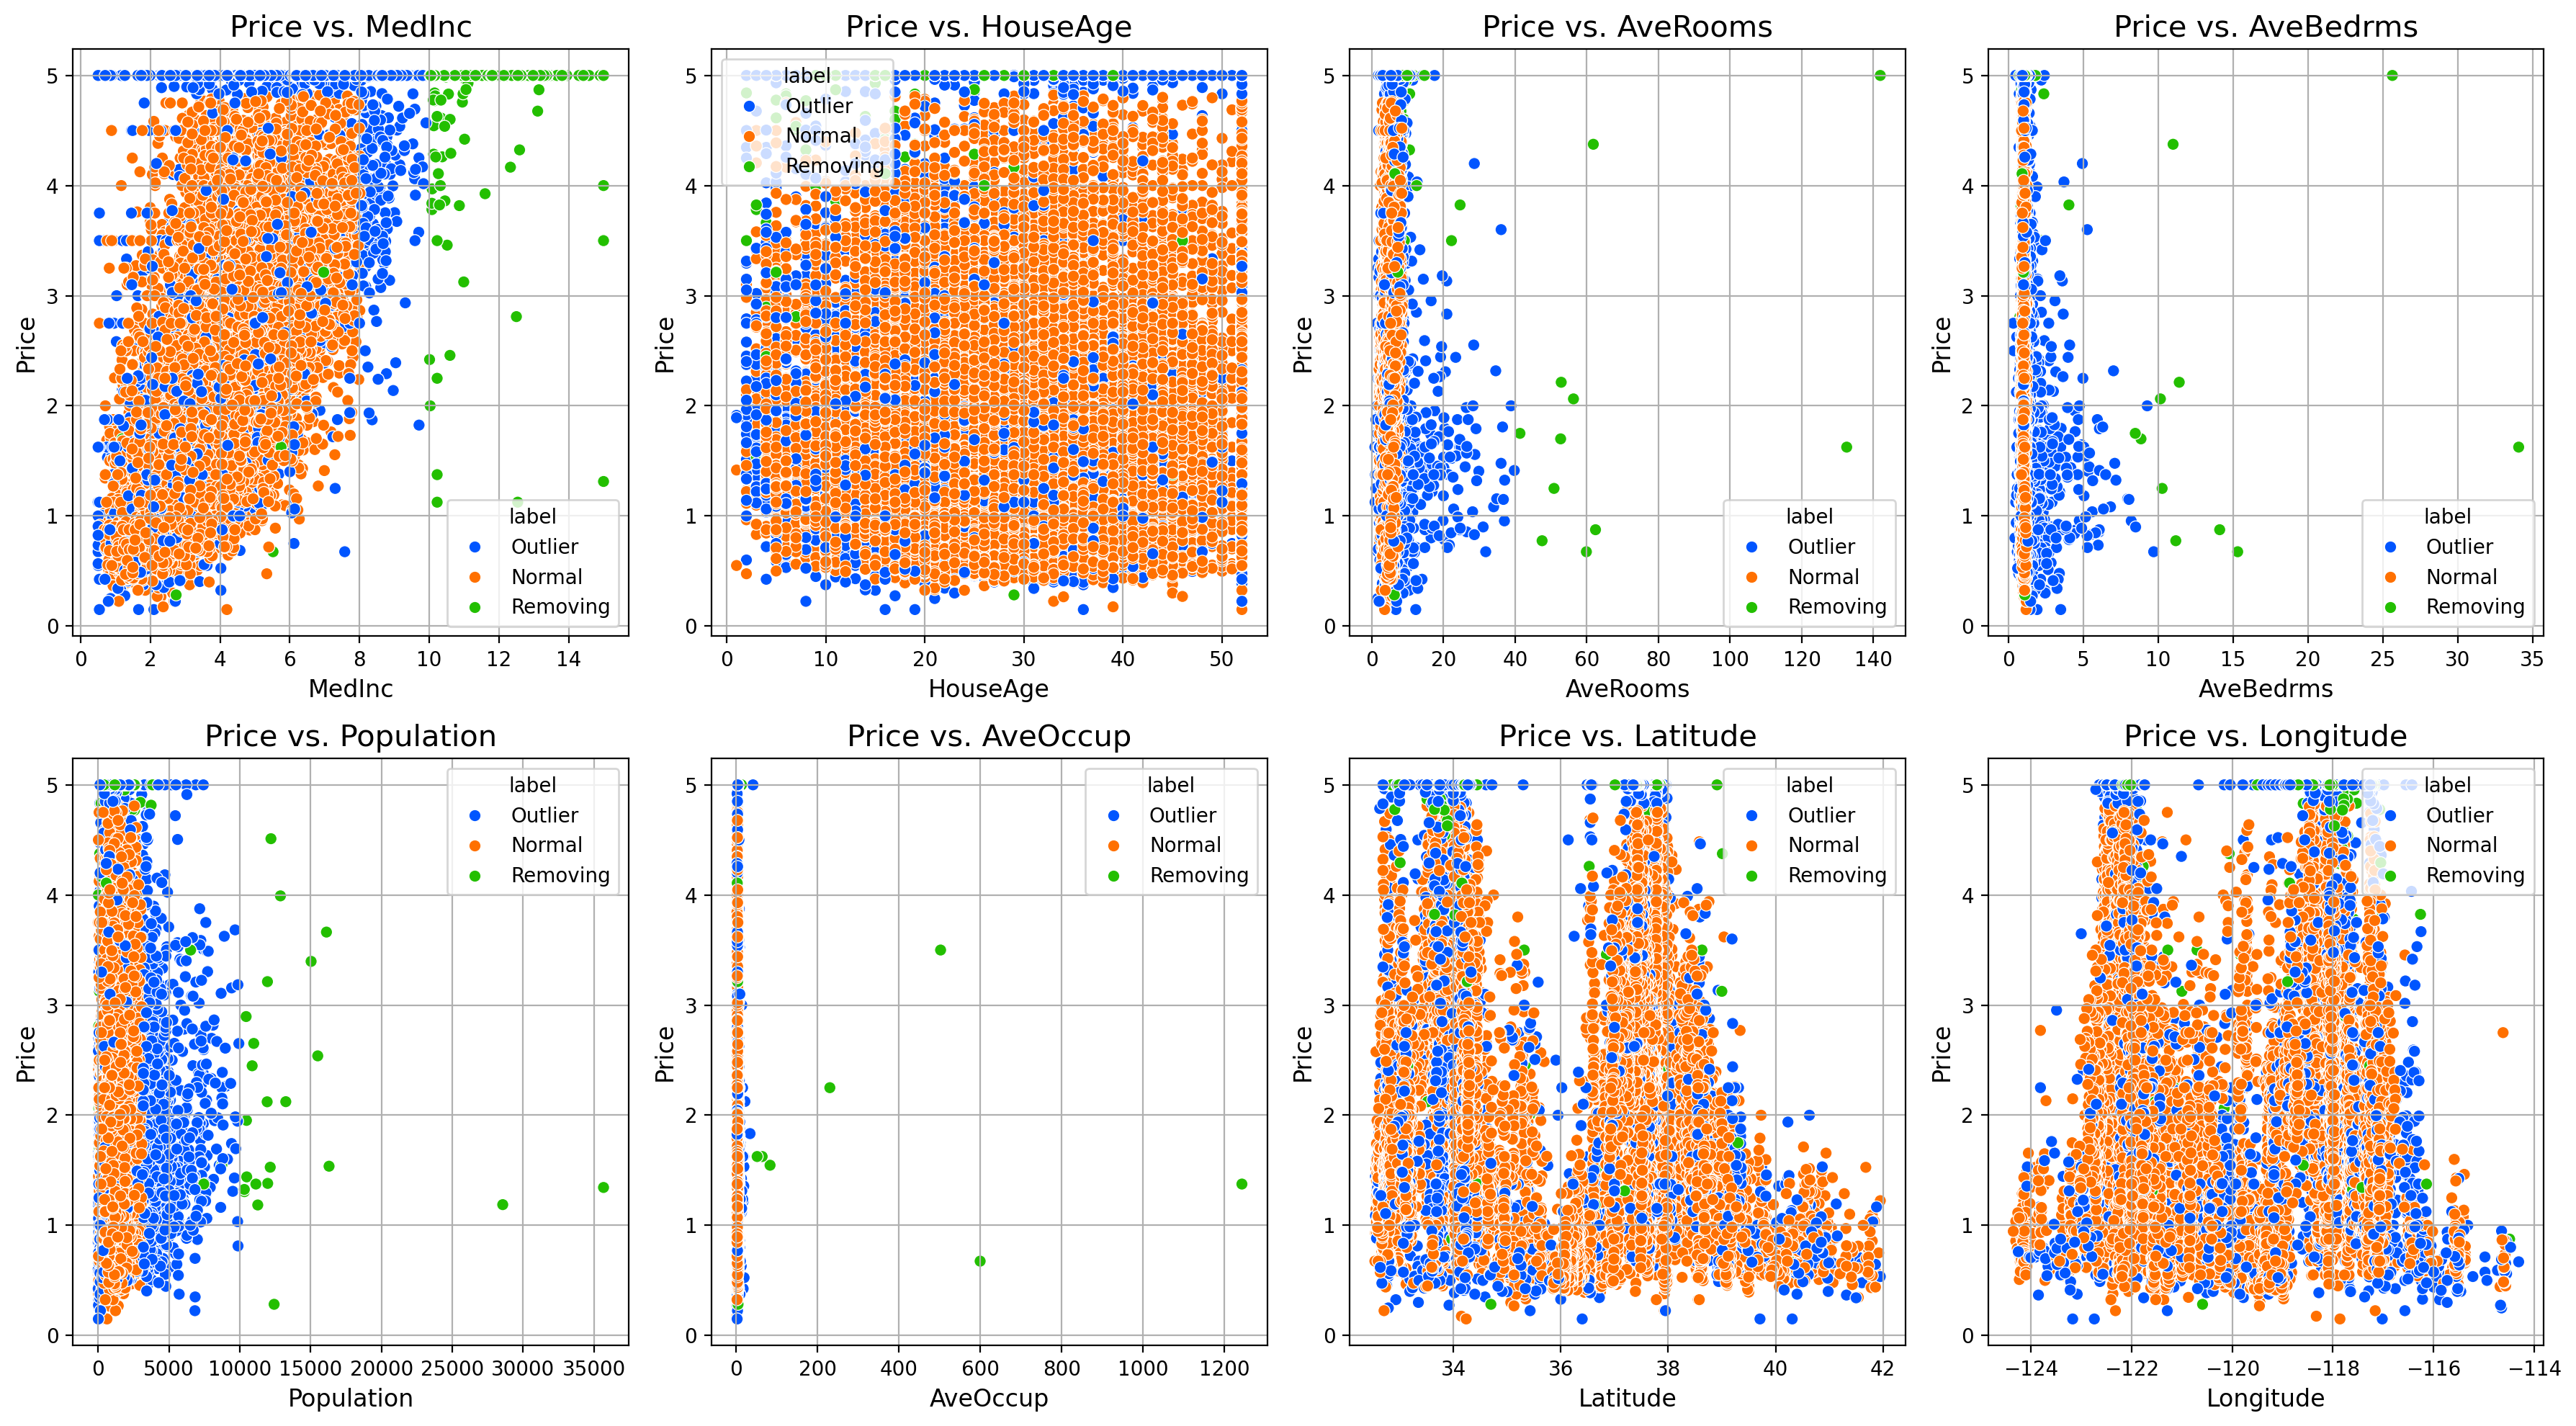

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 复制原数据集
df1 = house_price_dataframe.copy()

# 标记异常值和删除行
df1['label'] = 'Normal'
df1.loc[outliers_indexes, 'label'] = 'Outlier'

# 去除特定条件下的值
removing_indexes = []
removing_indexes.extend(df1[df1['MedInc'] > 10].index)
removing_indexes.extend(df1[df1['AveRooms'] > 40].index)
removing_indexes.extend(df1[df1['AveBedrms'] > 15].index)
removing_indexes.extend(df1[df1['Population'] > 10000].index)
removing_indexes.extend(df1[df1['AveOccup'] > 50].index)
df1.loc[removing_indexes, 'label'] = 'Removing'

# 获取特征列，去掉目标变量
target = 'Price'
features = house_price_dataframe.columns.drop(target)

# 自定义调色板
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

# 动态计算子图的行列数
num_features = len(features)
ncols = 4  # 每行显示4个图
nrows = (num_features + ncols - 1) // ncols  # 根据特征数量动态计算行数

# 创建图形和子图
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows), dpi=200)

# 绘制每个特征与目标变量之间的关系
for i, feature in enumerate(features):
    x = i // ncols  # 计算当前特征的行数
    y = i % ncols   # 计算当前特征的列数
    sns.scatterplot(data=df1, x=feature, y=target, hue='label', ax=ax[x, y], palette=CustomPalette)
    ax[x, y].set_title(f'{target} vs. {feature}', size=15)
    ax[x, y].set_xlabel(feature, size=12)
    ax[x, y].set_ylabel(target, size=12)
    ax[x, y].grid(True)

# 调整子图布局，避免重叠
plt.savefig("房价预测-离群点去除.png", dpi=300, bbox_inches='tight') 
plt.tight_layout()
plt.show()


In [11]:
removing_indexes = list(set(removing_indexes))

In [12]:
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)

In [13]:
df1.shape

(20292, 10)

In [21]:
df1.to_csv("清洗数据.csv", index=False)